In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<h1>Gaussian Mixtures</h1>
<hr>
<h2>Reading the Data</h2>
The spreadsheet <b>Bitcoindata.xls</b> contains the exchange rate for Bitcoin over the period August 2017 - August 2018.


In [2]:
# read data into dataframe
df = pd.read_excel('Bitcoindata.xls',index_col='Date')

In [3]:
# sort the data ascending 
df.sort_index(ascending=True,inplace=True)

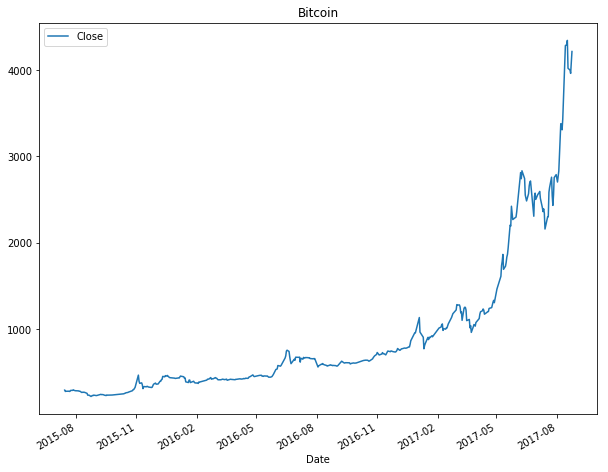

In [4]:
df.plot(figsize=(10,8),title='Bitcoin');

Calculate the log returns

In [5]:

df['Ret']= df['Close'].pct_change(periods=1)
df['LogRet'] = df['Ret'].apply(lambda x: np.log(1+x))
df.replace([np.inf, -np.inf], np.nan,inplace=True)
df.dropna(inplace=True)

Calculate the Volatility

In [6]:
print('Volatility of Bitcoin =',np.round(df['LogRet'].std()*np.sqrt(250)*100,2), '%')

Volatility of Bitcoin = 73.87 %


<h2> Are Bitcoin prices Normally distributed ?</h2>

In [7]:
from scipy import stats

The classical (visual) check to see if a dataset is having a normal distribution is via a <b> QQ Plot</b>. This takes place in 3 steps:
<ol>
<li>Determine a selection of quantiles/percentiles : 10th, 20th,...
<li>For both the theoretical (=normal distribution) and the empirical (=Bitcoin returns) distribution calculate the values of these quantiles/percentiles
<li>Plot both quantiles versus each other
</ol>
The datapoints should be on a straight line if our dataset is following a normal distribution.
<br>


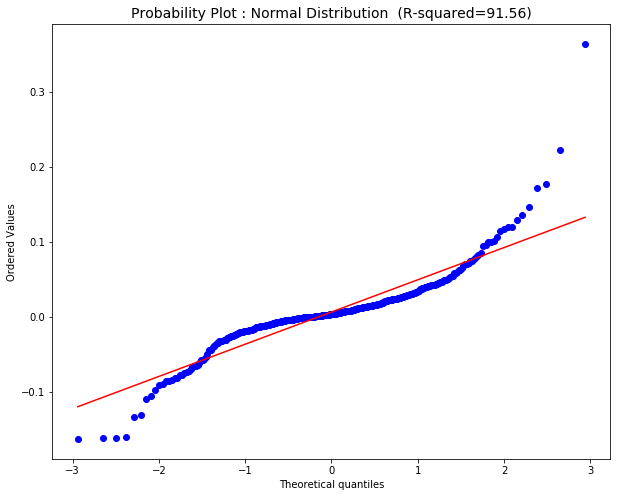

In [8]:
fig , ax = plt.subplots(1,1,figsize=(10,8))
data = np.array(df['LogRet'])
res = stats.probplot(data,fit=True,plot=ax,dist='norm')
R = np.round(100*res[-1][-1],2)
ax.set_title('Probability Plot : Normal Distribution  (R-squared='+str(R)+')',fontsize=14);

A better candidate to replace the normal distribution function is the laplace-function:

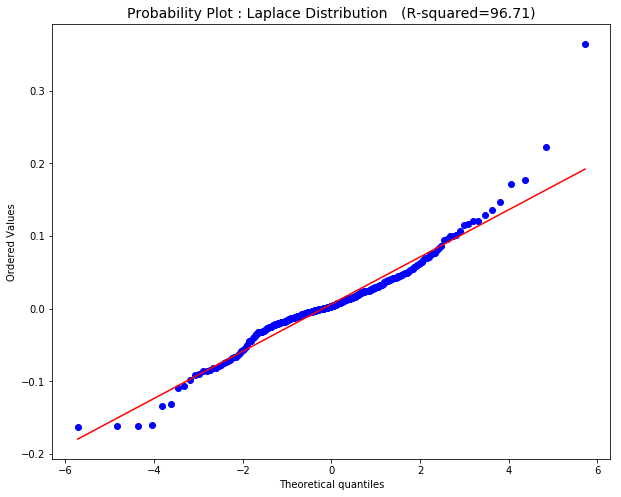

In [9]:
fig , ax = plt.subplots(1,1,figsize=(10,8))
data = np.array(df['LogRet'])
res = stats.probplot(data,fit=True,plot=ax,dist='laplace')
R = np.round(100*res[-1][-1],2)
ax.set_title('Probability Plot : Laplace Distribution   (R-squared='+str(R)+')',fontsize=14);

The <b>Kolmogorov-Smirnov</b> test. <br>
Using the cumulative density function (<b>CDF</b>) of the returns and compare those with a fitted CDF using the kolmogorov-smirnov two sample test (scipy.stats.kstest). <br>
This test will allow us to verify of the CDF of the two series come from the same distribution ( in our case the Normal distribution function) <br>
The kstest outputs:
<ol>
<li>the ks statistic
<li> a p-value
</ol></br>
<br>
P-values less than 0.05 means we can reject the null hypothesis that the two series were drawn from the same distribution. The smaller the p-value the more confident we are that they came from a different distributions.

First we will analyze the entire return series, then compare the test across years.

Documentation : https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html
 

In [10]:
print('Testing normal distribution:',stats.kstest(data, 'norm'))
print('->Reject Null hypothesis given the small p value')

Testing normal distribution: KstestResult(statistic=0.4422787810822094, pvalue=0.0)
->Reject Null hypothesis given the small p value


<h2>Gaussian Mixture</h2>
Studying the bitcoin returns as the combination of <b>three</b> gaussians. Each gaussian represents a <b>regime</b>

In [11]:
from sklearn import mixture

In [12]:
clf = mixture.GaussianMixture(n_components=3)
clf.fit(data.reshape(-1,1))


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

Now looping over the differrence regime to find for each regim the <b>mean</b> and the <b>standard deviation </b>

In [13]:
for i in np.arange(0,len(clf.weights_)):
    print('Regime',i,np.round(100*clf.weights_[i],2),'%',
          '[Mean=',np.round(100*clf.means_[i,0],2),
          '%, StDev=',np.round(100*np.sqrt(clf.covariances_[i][0,0]),2),']')

Regime 0 12.8 % [Mean= 6.35 %, StDev= 7.59 ]
Regime 1 78.65 % [Mean= 0.59 %, StDev= 1.92 ]
Regime 2 8.55 % [Mean= -7.51 %, StDev= 4.41 ]


How does one know which regime we are in ?

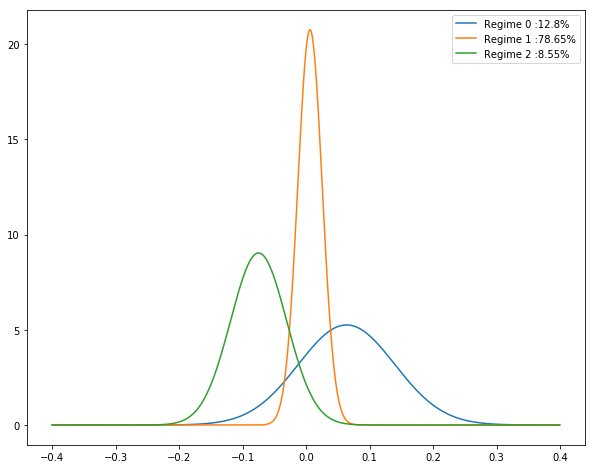

In [14]:
fig = plt.subplots(1,1,figsize=(10,8))
x = np.arange(-0.4,0.4,0.001)
for i in np.arange(0,len(clf.weights_)):
    plt.plot(x,
             stats.norm.pdf(x,loc=clf.means_[i,0],scale=np.sqrt(clf.covariances_[i][0,0])),
             label='Regime '+str(i)+' :'+str(np.round(100*clf.weights_[i],2))+'%')
    plt.legend()

In [15]:

predicted_regime = clf.predict(data.reshape(-1,1))

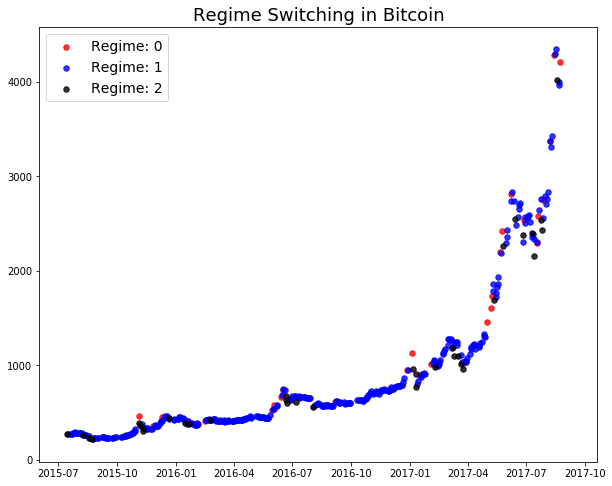

In [16]:
fig = plt.subplots(1,1,figsize=(10,8))
for r,c in zip(np.unique(predicted_regime),['r','b','k']):
    plt.scatter(df.index[predicted_regime==r],df['Close'].values[[predicted_regime==r]],label='Regime: ' + str(r),c=c,alpha=0.8,s=30)
plt.legend(loc=2,fontsize=14);
plt.title('Regime Switching in Bitcoin',fontsize=18);